In [1]:
import torch
from networks.DVT import converters
import datasets
from config import config_MOS as config
from networks import backbone
import deep_point
import matplotlib.pyplot as plt

In [2]:
def VoxelMaxPool(pcds_feat, pcds_ind, output_size, scale_rate):
    voxel_feat = deep_point.VoxelMaxPool(
        pcds_feat=pcds_feat.contiguous(),
        pcds_ind=pcds_ind.contiguous(),
        output_size=output_size,
        scale_rate=scale_rate,
    ).to(pcds_feat.dtype)
    return voxel_feat

def generate_img_labels(coord, label, size):
    coord = torch.clone(coord[:1, :, :2, :])  # 1, 160000, 2, 1
    label = torch.clone(label).unsqueeze(0).unsqueeze(0)  # 1, 1, 160000, 1

    img_label = (
        VoxelMaxPool(
            pcds_feat=label,
            pcds_ind=coord,
            output_size=size,
            scale_rate=(1.0, 1.0),
        )
        .squeeze(0)
        .squeeze(0)
        .unsqueeze(-1)
    )
    
    return img_label  # H, W, 1

def transform_view(feat, des_coord, sph_coord):
    if feat.shape[2] == feat.shape[3]:  # square(from : BEV)
        return des_2_sph_2d2d(feat, des_coord)

    else:  # rectangular(from : RV)
        return sph_2_des_2d2d(feat, sph_coord)


def des_2_sph_2d2d(bev_feat, descartes_coord_t_0):
    """
    BEV → RV direct max-pool
    bev_feat: (B, C, Hb, Wb)
    descartes_coord_t_0: (B, 160000, 3, 1)
    """
    BS, C, Hb, Wb = bev_feat.shape

    bev_z_in = VoxelMaxPool(
        pcds_feat=descartes_coord_t_0[:, :, 2:3, :].permute(0, 2, 1, 3).contiguous(),  # (BS, 1, N, 1)
        pcds_ind=descartes_coord_t_0[:, :, :2, :],  # (BS, N, 2, 1)
        output_size=(Hb, Wb),
        scale_rate=(Hb / 512, Wb / 512),
    ).view(BS, -1, Hb, Wb)

    return converters["BEV2RV"][Hb](bev_feat, bev_z_in)

def sph_2_des_2d2d(rv_feat, sphere_coord_t_0):
    """
    RV → BEV direct max‐pool
    rv_feat : (B, C, Hr, Wr)
    sphere_coord_t_0 : (B, 160000, 3, 1)
    """
    BS, C, Hr, Wr = rv_feat.shape

    sph_range_in = VoxelMaxPool(
        pcds_feat=sphere_coord_t_0[:, :, 2:3, :].permute(0, 2, 1, 3).contiguous(),  # (BS, 1, N, 1)
        pcds_ind=sphere_coord_t_0[:, :, :2, :],  # (BS, N, 2, 1)
        output_size=(Hr, Wr),
        scale_rate=(Hr / 64, Wr / 2048),
    ).view(BS, -1, Hr, Wr)

    return converters["RV2BEV"][Hr](rv_feat, sph_range_in)

In [3]:
pGen, pDataset, pModel, pOpt = config.get_config()


FRAME = 40

val_dataset = datasets.data_MOS.DataloadVal(pDataset.Val)

(
    xyzi,
    descartes_coord,
    sphere_coord,
    label_3D,
    label_2D,
    valid_mask_list,
    pad_length_list,
    meta_list_raw,
) = val_dataset[FRAME]

xyzi = xyzi.unsqueeze(0)
descartes_coord = descartes_coord.unsqueeze(0)
sphere_coord = sphere_coord.unsqueeze(0)

sphere_label = generate_img_labels(sphere_coord[0], label_3D.float(), (64, 2048))

In [4]:
BS, T, C, N, _ = xyzi.shape

point_pre = backbone.PointNetStacker(7, 64, pre_bn=True, stack_num=2)

# PointNet
point_feats = point_pre(xyzi.view(BS * T, C, N, 1))  # (BS×3, 64, 160000, 1)

# Descartes BEV 투영 (BS, 192, 512, 512)
descartes_feat_in = VoxelMaxPool(
    pcds_feat=point_feats,  # (BS*T, 64, 160000, 1)
    pcds_ind=descartes_coord.view(BS * T, N, 3, 1)[:, :, :2],  # (BS*T, N, 2, 1)
    output_size=(512, 512),
    scale_rate=(1.0, 1.0),
).view(BS, -1, 512, 512)

sphere_feat_in = VoxelMaxPool(
    pcds_feat=point_feats,  # (BS*T, 64, 160000, 1)
    pcds_ind=sphere_coord.view(BS * T, N, 3, 1)[:, :, :2],  # (BS*T, N, 2, 1)
    output_size=(64, 2048),
    scale_rate=(1.0, 1.0),
).view(BS, -1, 64, 2048)

# t_0 시점 데이터(피처, c좌표, p좌표)
point_feats_t_0 = point_feats.view(BS, T, -1, N, 1)[:, 0].contiguous()  # (BS, 64, 160000, 1)
des_coord_t0 = descartes_coord[:, 0].contiguous()  # (BS, 160000, 3, 1)
sph_coord_t0 = sphere_coord[:, 0].contiguous()  # (BS, 160000, 3, 1)

In [5]:
torch.min(descartes_feat_in), torch.max(descartes_feat_in), torch.min(sphere_feat_in), torch.max(sphere_feat_in)

(tensor(0., grad_fn=<MinBackward1>),
 tensor(4.3924, grad_fn=<MaxBackward1>),
 tensor(0., grad_fn=<MinBackward1>),
 tensor(4.3924, grad_fn=<MaxBackward1>))

In [10]:
des_as_sph = transform_view(descartes_feat_in, des_coord_t0, sph_coord_t0)  # (BS, C=32, H=32, W=1024)
sph_as_des = transform_view(sphere_feat_in, des_coord_t0, sph_coord_t0)  # (BS, C=32, H=32, W=1024)

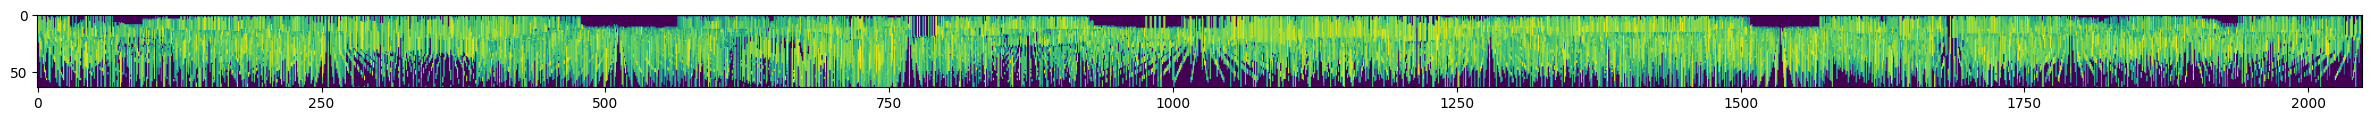

In [14]:
image = torch.max(des_as_sph, dim=1)[0][0].detach().cpu().numpy()
plt.figure(figsize=(30, 4))
plt.imshow(image)

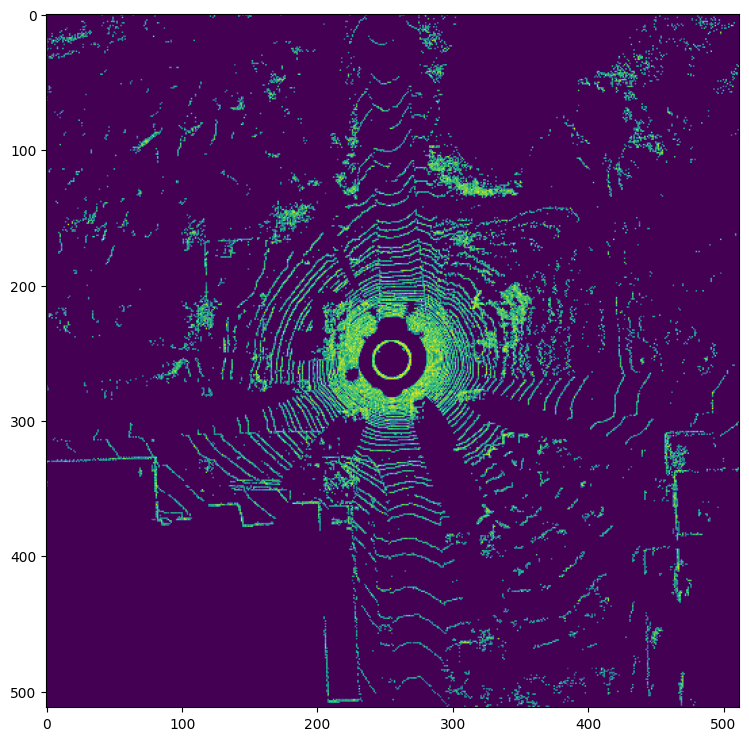

In [15]:
image = torch.max(sph_as_des, dim=1)[0][0].detach().cpu().numpy()
plt.figure(figsize=(9, 9))
plt.imshow(image)

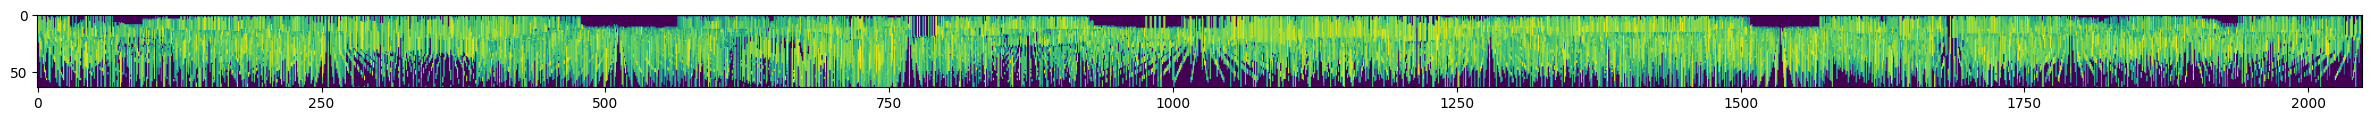

In [13]:
transformed = transform_view(descartes_feat_in, des_coord_t0, sph_coord_t0)
# transformed = transform_view(transformed, des_coord_t0, sph_coord_t0)
image = torch.max(transformed, dim=1)[0][0].cpu().numpy()
plt.figure(figsize=(30, 4))
plt.imshow(image)

torch.Size([64, 2048, 1])


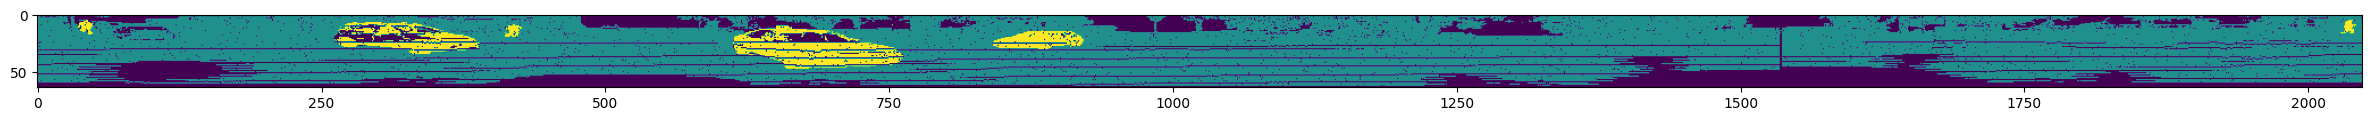

In [16]:
print(sphere_label.shape)
plt.figure(figsize=(30, 4))
plt.imshow(sphere_label.cpu().numpy())

torch.Size([256, 256, 1])


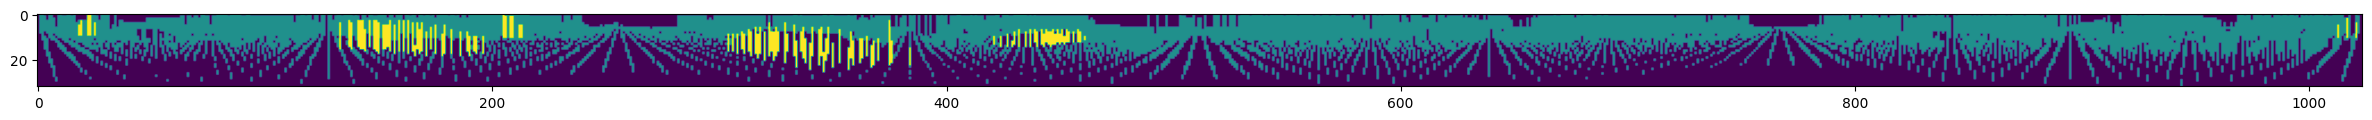

In [17]:
print(label_2D.shape)
rv_label = transform_view(label_2D.permute(2, 0, 1).contiguous().unsqueeze(0), des_coord_t0, sph_coord_t0)[0][0].cpu().numpy()
plt.figure(figsize=(30, 4))
plt.imshow(rv_label)

torch.Size([1, 1, 64, 2048])


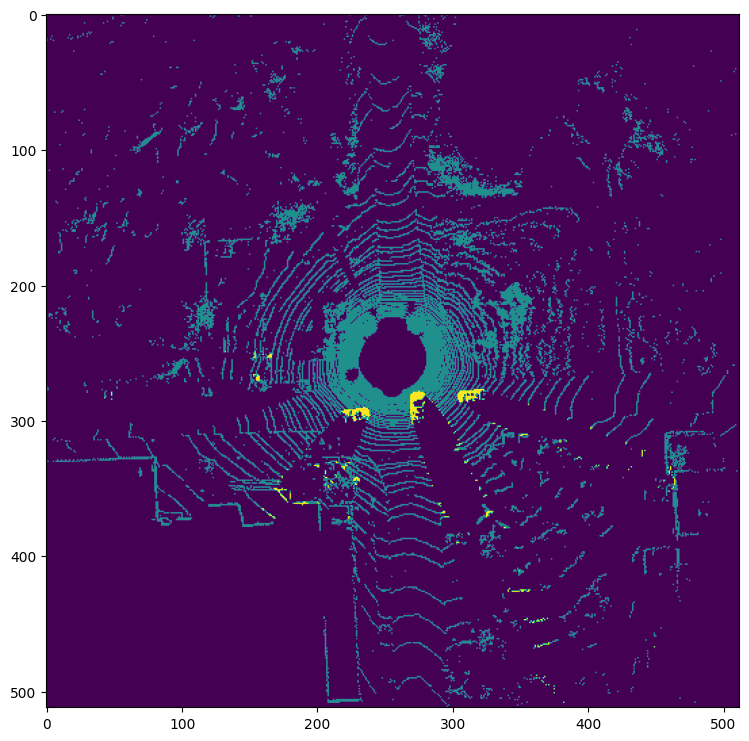

In [18]:
rv_label_tensor = sphere_label.unsqueeze(0).unsqueeze(0).squeeze(-1)
print(rv_label_tensor.shape)
bev_label_again = transform_view(rv_label_tensor, des_coord_t0, sph_coord_t0)[0][0].cpu().numpy()
plt.figure(figsize=(9, 9))
plt.imshow(bev_label_again)

torch.Size([1, 1, 32, 1024])


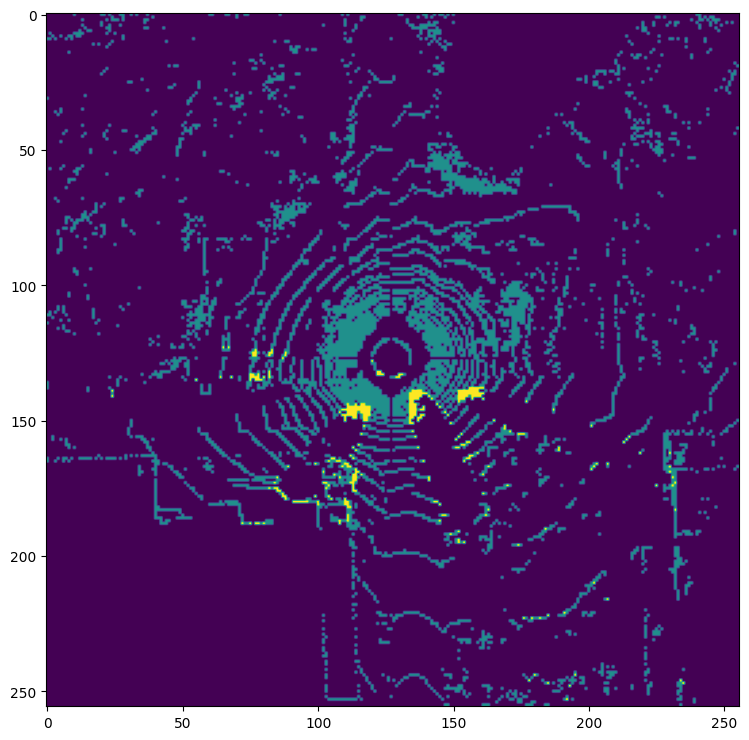

In [9]:
rv_label_tensor = torch.from_numpy(rv_label).unsqueeze(0).unsqueeze(0)
print(rv_label_tensor.shape)
bev_label_again = transform_view(rv_label_tensor, des_coord_t0, sph_coord_t0)[0][0].cpu().numpy()
plt.figure(figsize=(9, 9))
plt.imshow(bev_label_again)